# NEF summary

The Neural Engineering Framework (NEF)
is one set of theoretical methods that are used in
Nengo for constructing neural models.
The NEF is based on [Eliasmith & Anderson's (2003) book](
https://mitpress.mit.edu/books/neural-engineering) from MIT Press.
This notebook introduces the three main principles
discussed in that book and implemented in Nengo.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ipython import hide_input
from nengo.utils.matplotlib import rasterplot


def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons)
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1))
    intercepts *= encoders[:, 0]
    return intercepts, encoders


hide_input()

## Principle 1: Representation

### Encoding

Neural populations represent time-varying signals
through their spiking responses.
A signal is a vector of real numbers of arbitrary length.
This example is a 1D signal going from -1 to 1 in 1 second.

In [2]:
model = nengo.Network(label="NEF summary")
with model:
    input = nengo.Node(lambda t: t * 2 - 1)
    input_probe = nengo.Probe(input)

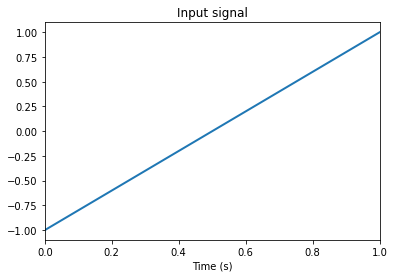

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(1.0)

plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], lw=2)
plt.title("Input signal")
plt.xlabel("Time (s)")
plt.xlim(0, 1);
hide_input()

These signals drive neural populations
based on each neuron's *tuning curve*
(which is similar to the current-frequency curve,
if you're familiar with that).

The tuning curve describes how much
a particular neuron will fire as a function of the input signal.

In [4]:
intercepts, encoders = aligned(8)  # Makes evenly spaced intercepts
with model:
    A = nengo.Ensemble(
        8,
        dimensions=1,
        intercepts=intercepts,
        max_rates=Uniform(80, 100),
        encoders=encoders)

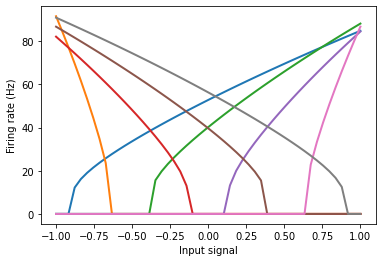

In [5]:
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(A, sim)

plt.figure()
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)");
hide_input()

We can drive these neurons with our input signal
and observe their spiking activity over time.

In [6]:
with model:
    nengo.Connection(input, A)
    A_spikes = nengo.Probe(A.neurons)

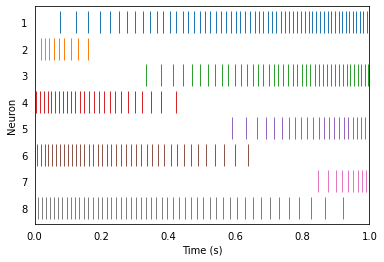

In [7]:
with nengo.Simulator(model) as sim:
    sim.run(1)

plt.figure()
ax = plt.subplot(1, 1, 1)
rasterplot(sim.trange(), sim.data[A_spikes], ax)
ax.set_xlim(0, 1)
ax.set_ylabel('Neuron')
ax.set_xlabel('Time (s)');
hide_input()

### Decoding

We can estimate the input signal
originally encoded by decoding the pattern of spikes.
To do this, we first filter the spike train
with a temporal filter that accounts for
postsynaptic current (PSC) activity.

In [8]:
model = nengo.Network(label="NEF summary")
with model:
    input = nengo.Node(lambda t: t * 2 - 1)
    input_probe = nengo.Probe(input)
    intercepts, encoders = aligned(8)  # Makes evenly spaced intercepts
    A = nengo.Ensemble(8, dimensions=1,
                       intercepts=intercepts,
                       max_rates=Uniform(80, 100),
                       encoders=encoders)
    nengo.Connection(input, A)
    A_spikes = nengo.Probe(A.neurons, synapse=0.01)

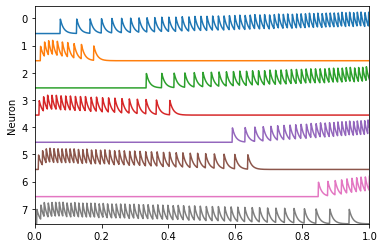

In [9]:
with nengo.Simulator(model) as sim:
    sim.run(1)

scale = 180
plt.figure()
for i in range(A.n_neurons):
    plt.plot(sim.trange(), sim.data[A_spikes][:, i] - i * scale)
plt.xlim(0, 1)
plt.ylim(scale * (-A.n_neurons + 1), scale)
plt.ylabel("Neuron")
plt.yticks(
    np.arange(scale / 1.8, (-A.n_neurons + 1) * scale, -scale),
    np.arange(A.n_neurons))
hide_input()

Then we mulitply those filtered spike trains
with decoding weights and sum them together
to give an estimate of the input based on the spikes.

The decoding weights are determined
by minimizing the squared difference
between the decoded estimate and the actual input signal.

In [10]:
with model:
    A_probe = nengo.Probe(A, synapse=0.01)  # 10ms PSC filter

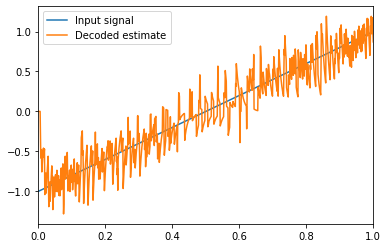

In [11]:
with nengo.Simulator(model) as sim:
    sim.run(1)

plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.plot(sim.trange(), sim.data[A_probe], label="Decoded estimate")
plt.legend(loc="best")
plt.xlim(0, 1)
hide_input()

The accuracy of the decoded estimate increases
as the number of neurons increases.

In [12]:
model = nengo.Network(label="NEF summary")
with model:
    input = nengo.Node(lambda t: t * 2 - 1)
    input_probe = nengo.Probe(input)
    A = nengo.Ensemble(30, dimensions=1, max_rates=Uniform(80, 100))
    nengo.Connection(input, A)
    A_spikes = nengo.Probe(A.neurons)
    A_probe = nengo.Probe(A, synapse=0.01)

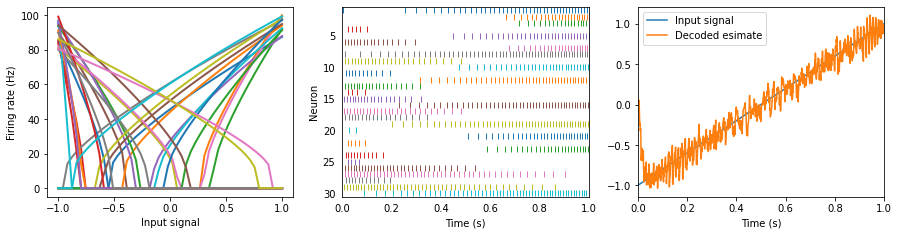

In [13]:
with nengo.Simulator(model) as sim:
    sim.run(1)

plt.figure(figsize=(15, 3.5))

plt.subplot(1, 3, 1)
eval_points, activities = tuning_curves(A, sim)
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)")

ax = plt.subplot(1, 3, 2)
rasterplot(sim.trange(), sim.data[A_spikes], ax)
plt.xlim(0, 1)
plt.xlabel("Time (s)")
plt.ylabel("Neuron")

plt.subplot(1, 3, 3)
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.plot(sim.trange(), sim.data[A_probe], label="Decoded esimate")
plt.legend(loc="best")
plt.xlabel("Time (s)")
plt.xlim(0, 1)
hide_input()

Any smooth signal can be encoded and decoded.

In [14]:
model = nengo.Network(label="NEF summary")
with model:
    input = nengo.Node(WhiteSignal(1, high=5), size_out=1)
    input_probe = nengo.Probe(input)
    A = nengo.Ensemble(30, dimensions=1, max_rates=Uniform(80, 100))
    nengo.Connection(input, A)
    A_spikes = nengo.Probe(A.neurons)
    A_probe = nengo.Probe(A, synapse=0.01)

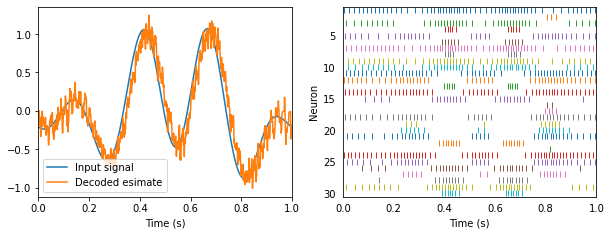

In [15]:
with nengo.Simulator(model) as sim:
    sim.run(1)

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.plot(sim.trange(), sim.data[A_probe], label="Decoded esimate")
plt.legend(loc="best")
plt.xlabel("Time (s)")
plt.xlim(0, 1)

ax = plt.subplot(1, 2, 2)
rasterplot(sim.trange(), sim.data[A_spikes], ax)
plt.xlim(0, 1)
plt.xlabel("Time (s)")
plt.ylabel("Neuron")
hide_input()

## Principle 2: Transformation

Encoding and decoding allow us to encode signals over time,
and decode transformations of those signals.

In fact, we can decode arbitrary transformations of the input signal,
not just the signal itself (as in the previous example).

Let's decode the square of our white noise input.

In [16]:
model = nengo.Network(label="NEF summary")
with model:
    input = nengo.Node(WhiteSignal(1, high=5), size_out=1)
    input_probe = nengo.Probe(input, )
    A = nengo.Ensemble(30, dimensions=1, max_rates=Uniform(80, 100))
    Asquare = nengo.Node(size_in=1)
    nengo.Connection(input, A)
    nengo.Connection(A, Asquare, function=np.square)
    A_spikes = nengo.Probe(A.neurons)
    Asquare_probe = nengo.Probe(Asquare, synapse=0.01)

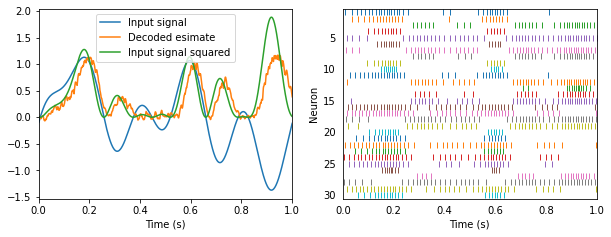

In [17]:
with nengo.Simulator(model) as sim:
    sim.run(1)

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(
    sim.trange(),
    sim.data[input_probe],
    label="Input signal")
plt.plot(
    sim.trange(),
    sim.data[Asquare_probe],
    label="Decoded esimate")
plt.plot(
    sim.trange(),
    np.square(sim.data[input_probe]),
    label="Input signal squared")
plt.legend(loc="best", fontsize='medium')
plt.xlabel("Time (s)")
plt.xlim(0, 1)

ax = plt.subplot(1, 2, 2)
rasterplot(sim.trange(), sim.data[A_spikes])
plt.xlim(0, 1)
plt.xlabel("Time (s)")
plt.ylabel("Neuron")
hide_input()

Notice that the spike trains are exactly the same.
The only difference is how we're interpreting those spikes.
We told Nengo to compute a new set of decoders
that estimate the function $x^2$.

In general, the transformation principle
determines how we can decode spike trains
to compute linear and nonlinear transformations of signals
encoded in a population of neurons.
We can then project those transformed signals
into another population, and repeat the process.
Essentially, this provides a means of
computing the neural connection weights
to compute an arbitrary function between populations.

Suppose we are representing a sine wave.

In [18]:
model = nengo.Network(label="NEF summary")
with model:
    input = nengo.Node(lambda t: np.sin(np.pi * t))
    A = nengo.Ensemble(30, dimensions=1, max_rates=Uniform(80, 100))
    nengo.Connection(input, A)
    A_spikes = nengo.Probe(A.neurons)
    A_probe = nengo.Probe(A, synapse=0.01)

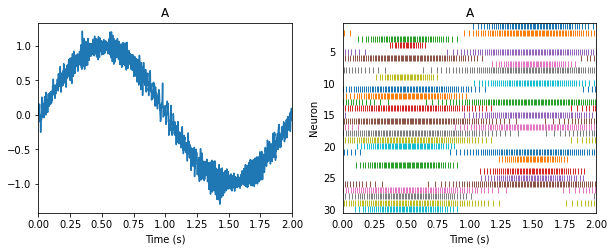

In [19]:
with nengo.Simulator(model) as sim:
    sim.run(2)

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(sim.trange(), sim.data[A_probe])
plt.title("A")
plt.xlabel("Time (s)")
plt.xlim(0, 2)

ax = plt.subplot(1, 2, 2)
rasterplot(sim.trange(), sim.data[A_spikes], ax)
plt.xlim(0, 2)
plt.title("A")
plt.xlabel("Time (s)")
plt.ylabel("Neuron")
hide_input()

Linear transformations of that signal
involve solving for the usual decoders,
and scaling those decoding weights.
Let us flip this sine wave upside down
as it is transmitted between two populations
(i.e. population A and population -A).

In [20]:
with model:
    minusA = nengo.Ensemble(30, dimensions=1, max_rates=Uniform(80, 100))
    nengo.Connection(A, minusA, function=lambda x: -x)
    minusA_spikes = nengo.Probe(minusA.neurons)
    minusA_probe = nengo.Probe(minusA, synapse=0.01)

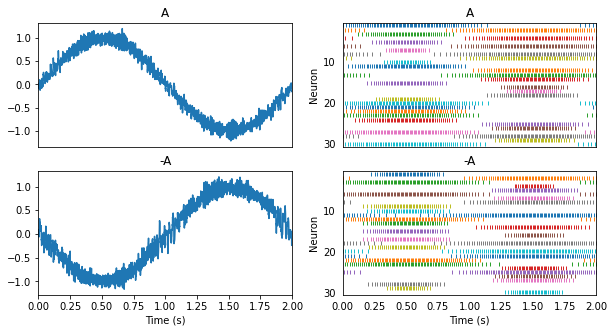

In [21]:
with nengo.Simulator(model) as sim:
    sim.run(2)

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.plot(sim.trange(), sim.data[A_probe])
plt.title("A")
plt.xticks(())
plt.xlim(0, 2)

plt.subplot(2, 2, 3)
plt.plot(sim.trange(), sim.data[minusA_probe])
plt.title("-A")
plt.xlabel("Time (s)")
plt.xlim(0, 2)

ax = plt.subplot(2, 2, 2)
rasterplot(sim.trange(), sim.data[A_spikes], ax)
plt.xlim(0, 2)
plt.title("A")
plt.xticks(())
plt.ylabel("Neuron")

ax = plt.subplot(2, 2, 4)
rasterplot(sim.trange(), sim.data[minusA_spikes], ax)
plt.xlim(0, 2)
plt.title("-A")
plt.xlabel("Time (s)")
plt.ylabel("Neuron")
hide_input()

Nonlinear transformations involve
solving for a new set of decoding weights.
Let us add a third population connected
to the second one and use it to compute $(-A)^2$.

In [22]:
with model:
    A_squared = nengo.Ensemble(30, dimensions=1, max_rates=Uniform(80, 100))
    nengo.Connection(minusA, A_squared, function=lambda x: x ** 2)
    A_squared_spikes = nengo.Probe(A_squared.neurons)
    A_squared_probe = nengo.Probe(A_squared, synapse=0.02)

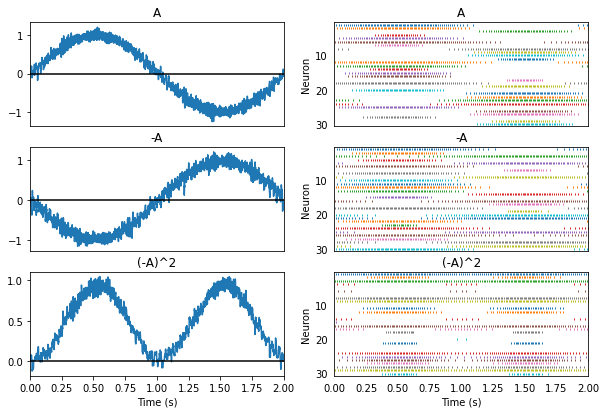

In [23]:
with nengo.Simulator(model) as sim:
    sim.run(2)

plt.figure(figsize=(10, 6.5))
plt.subplot(3, 2, 1)
plt.plot(sim.trange(), sim.data[A_probe])
plt.axhline(0, color='k')
plt.title("A")
plt.xticks(())
plt.xlim(0, 2)

plt.subplot(3, 2, 3)
plt.plot(sim.trange(), sim.data[minusA_probe])
plt.axhline(0, color='k')
plt.title("-A")
plt.xticks(())
plt.xlim(0, 2)

plt.subplot(3, 2, 5)
plt.plot(sim.trange(), sim.data[A_squared_probe])
plt.axhline(0, color='k')
plt.title("(-A)^2")
plt.xlabel("Time (s)")
plt.xlim(0, 2)

ax = plt.subplot(3, 2, 2)
rasterplot(sim.trange(), sim.data[A_spikes], ax)
plt.xlim(0, 2)
plt.title("A")
plt.xticks(())
plt.ylabel("Neuron")

ax = plt.subplot(3, 2, 4)
rasterplot(sim.trange(), sim.data[minusA_spikes], ax)
plt.xlim(0, 2)
plt.title("-A")
plt.xticks(())
plt.ylabel("Neuron")

ax = plt.subplot(3, 2, 6)
rasterplot(sim.trange(), sim.data[A_squared_spikes], ax)
plt.xlim(0, 2)
plt.title("(-A)^2")
plt.xlabel("Time (s)")
plt.ylabel("Neuron")
hide_input()

## Principle 3: Dynamics

So far, we have been considering the values
represented by ensembles as generic "signals."
However, if we think of them instead
as state variables in a dynamical system,
then we can apply the methods of control theory
or dynamic systems theory to brain models.
Nengo automatically translates from standard dynamical systems descriptions
to descriptions consistent with neural dynamics.

In order to get interesting dynamics,
we can connect populations recurrently (i.e., to themselves).

Below is a simple harmonic oscillator
implemented using this third principle.
It needs is a bit of input to get it started.

In [24]:
model = nengo.Network(label="NEF summary")
with model:
    input = nengo.Node(lambda t: [1, 0] if t < 0.1 else [0, 0])
    oscillator = nengo.Ensemble(200, dimensions=2)
    nengo.Connection(input, oscillator)
    nengo.Connection(
        oscillator, oscillator, transform=[[1, 1], [-1, 1]], synapse=0.1)
    oscillator_probe = nengo.Probe(oscillator, synapse=0.02)

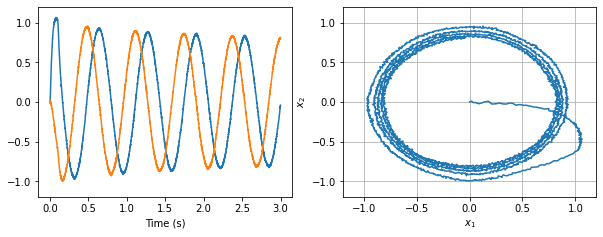

In [25]:
with nengo.Simulator(model) as sim:
    sim.run(3)

plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.plot(sim.trange(), sim.data[oscillator_probe])
plt.ylim(-1.2, 1.2)
plt.xlabel('Time (s)')

plt.subplot(1, 2, 2)
plt.plot(sim.data[oscillator_probe][:, 0], sim.data[oscillator_probe][:, 1])
plt.grid()
plt.axis([-1.2, 1.2, -1.2, 1.2])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
hide_input()